# Saliency Maps in CNNs

We are interested in understanding how certain parts of the network are responsible for respective outputs. Although they can be at any stage in the network, we focus here on the classical case of understanding the dependence of the output decision on the input pixels.

*Generated with the help of ChatGPT, verified and adapted/modified by Sven Krippendorf*


## Some simple CNN for image classification on CIFAR-10

CIFAR 10: https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
# for my local setup
!pip install jaxlib==0.3.22

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
import tensorflow.keras.layers as layers

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess the data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [3]:
np.shape(x_train)

(50000, 32, 32, 3)

In [4]:
# Define the model
inp = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32, (3, 3), activation="relu")(inp)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(10, activation="softmax")(x)

model = Model(inputs=inp,outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0     

In [5]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [6]:
# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
1563/1563 [==============================] - 6s 3ms/step - loss: 1.4651 - accuracy: 0.4711 - val_loss: 1.2399 - val_accuracy: 0.5571
Epoch 2/20
1563/1563 [==============================] - 4s 2ms/step - loss: 1.1093 - accuracy: 0.6071 - val_loss: 1.0260 - val_accuracy: 0.6410
Epoch 3/20
1563/1563 [==============================] - 4s 2ms/step - loss: 0.9772 - accuracy: 0.6574 - val_loss: 0.9984 - val_accuracy: 0.6520
Epoch 4/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.8884 - accuracy: 0.6900 - val_loss: 0.9452 - val_accuracy: 0.6748
Epoch 5/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.8193 - accuracy: 0.7156 - val_loss: 0.9146 - val_accuracy: 0.6857
Epoch 6/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.7550 - accuracy: 0.7373 - val_loss: 0.9203 - val_accuracy: 0.6885
Epoch 7/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.7024 - accuracy: 0.7555 - val_loss: 0.9157 - val_accuracy:

In [11]:
# Define a function to compute the saliency map for a model, given some input data x, and some class index class_idx
def compute_saliency_map(model, x, class_idx):
    """A function to compute the saliency map for a model.
       Input: some input data x, and some class index class_idx
       Output: max_channels(grad_{p}(f(image)) this is an array (len(x),dim_x(image),dim_y(image))"""
    x = tf.cast(x, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        logits = model(x)
        y = logits[:, class_idx]
    gradients = tape.gradient(y, x)
    saliency = tf.math.reduce_max(tf.abs(gradients), axis=-1) #keeping the maximum of the three gradient values
    return saliency

In [12]:
saliency = compute_saliency_map(model,[x_test[0]],np.argmax(y_test[0]))

In [54]:
y_test[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

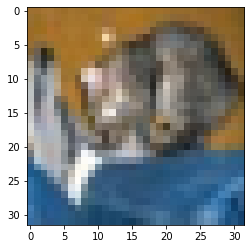

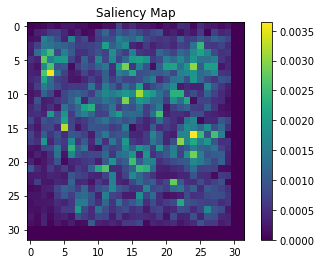

In [13]:
plt.imshow(x_test[0])
plt.show()
plt.imshow(saliency[0])
plt.title('Saliency Map')
plt.colorbar()

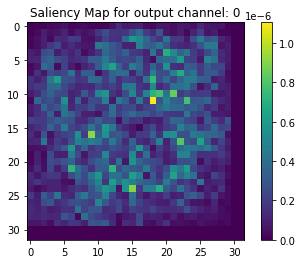

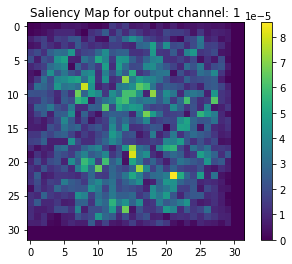

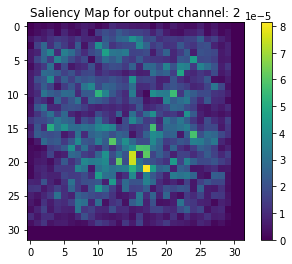

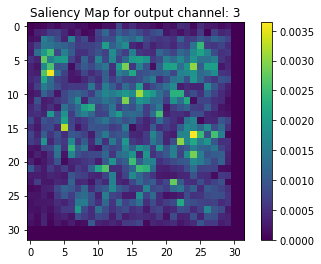

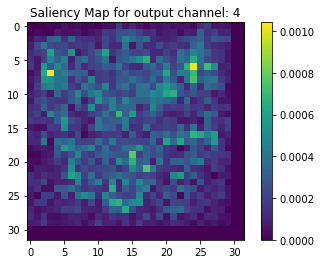

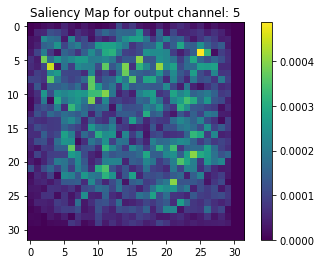

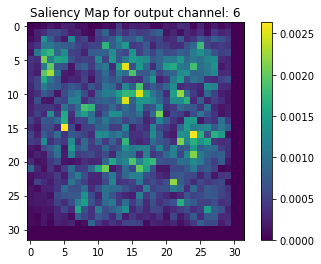

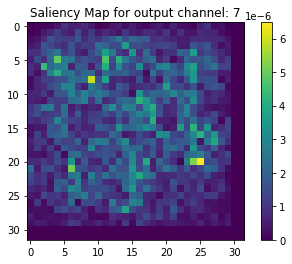

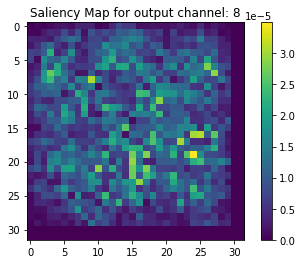

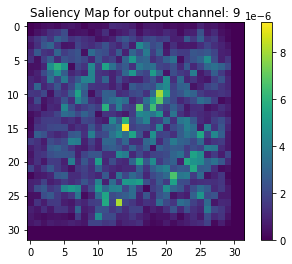

In [10]:
# Saliency map for different classes
for i in range(10):
    saliency = compute_saliency_map(model,[x_test[0]],i)
    plt.imshow(saliency[0])
    plt.title('Saliency Map for output channel: '+str(i))
    plt.colorbar()
    plt.show()

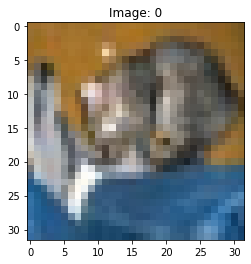

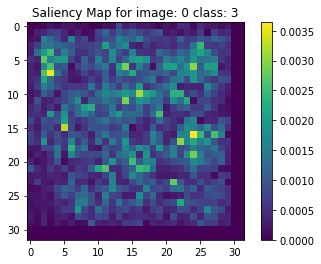

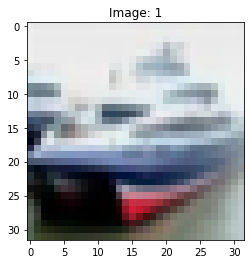

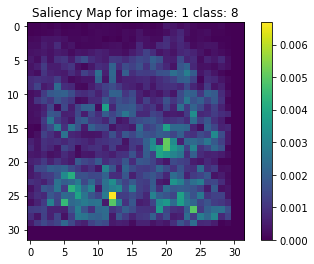

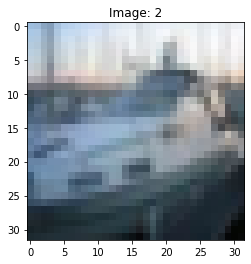

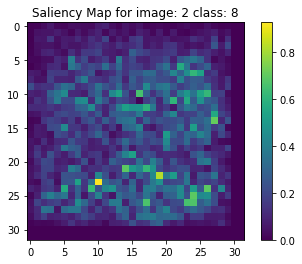

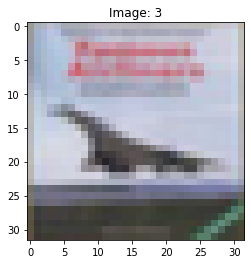

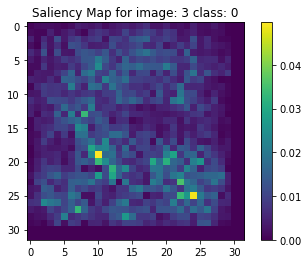

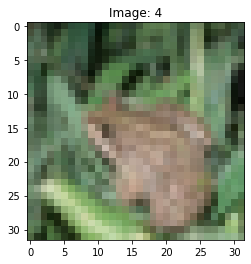

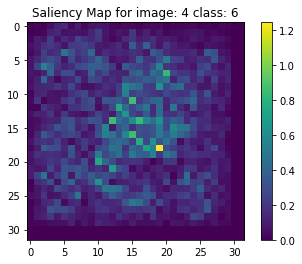

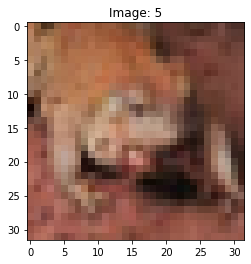

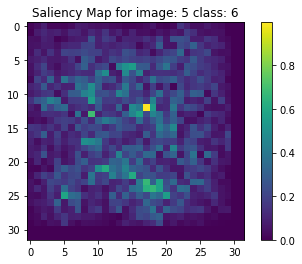

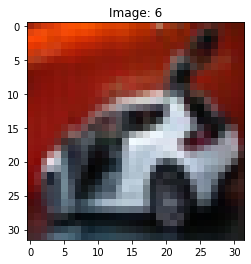

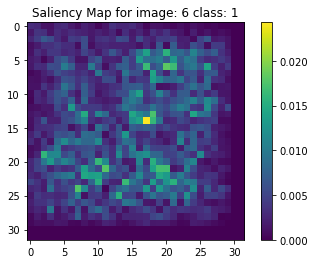

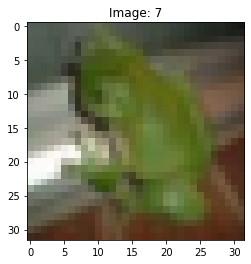

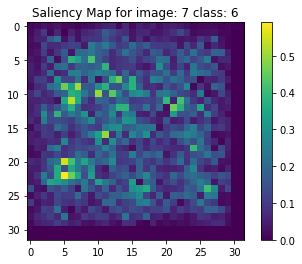

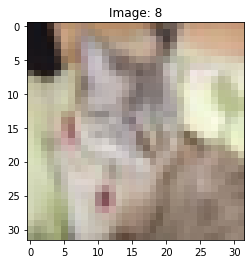

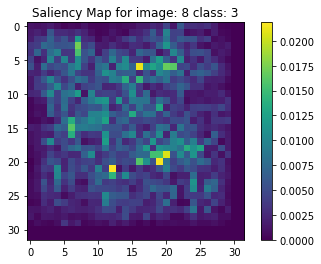

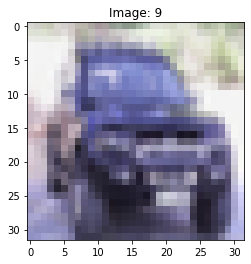

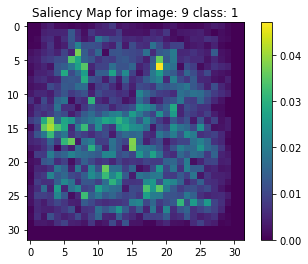

In [14]:
# Saliency map for different images
for i in range(10):
    saliency = compute_saliency_map(model,[x_test[i]],np.argmax(y_test[i]))
    plt.imshow(x_test[i])
    plt.title('Image: '+str(i))
    plt.show()
    plt.imshow(saliency[0])
    plt.title('Saliency Map for image: '+str(i)+ ' class: '+str(np.argmax(y_test[i])))
    plt.colorbar()
    plt.show()